In [155]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from mst_prim import prim_mst
from nemo import evaluate_nemo
import util
from util import lighten_color, get_max_by_thresh
import seaborn as sns
from util import centroid_label, coordinator_label, worker_label, ccolor, cmarker
from topology import get_lognorm_hist, setup_topology, get_lognorm_samples
import timeit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Topology Setup

In [115]:
seed = 4
np.random.seed(seed)

device_number = 1000 + 1
avg = 20
c_capacity = 50
max_resources = device_number * avg - 100

X_dim_range = [0, 100]
Y_dim_range = [-50, 50]
X_dim = [-10, 110]
Y_dim = [-60, 60]
centers = 40

H, bins = get_lognorm_hist()
prim_df, coords, c_coords, base_col, slot_columns, sums = setup_topology(H, max_resources, c_capacity, centers, X_dim_range, Y_dim_range, device_number - 1,
                                                                         seed=seed, weights=(1, avg*2), dist="lognorm")

eval_matrix = {}

In [116]:
prim_df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1
0,19.383905,7.406120,0.000000,coordinator,9223372036854775807,0,50,50,50,50,50,50,50,50,50,50,50,50
1,67.743232,-14.007158,52.888118,worker,9223372036854775807,1,20,19,20,22,18,16,24,19,43,19,22,18
2,5.220579,-15.467092,26.903228,worker,9223372036854775807,1,20,22,19,17,18,15,25,20,43,19,26,0
3,43.521014,41.129903,41.471599,worker,9223372036854775807,5,20,21,22,21,18,25,16,13,14,13,15,3
4,14.195029,1.412734,7.927491,worker,9223372036854775807,2,20,20,20,25,24,28,14,22,25,9,68,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,14.908514,-3.352142,11.652010,worker,9223372036854775807,2,20,21,19,18,23,21,14,22,11,25,9,45
997,39.672067,34.499402,33.847532,worker,9223372036854775807,40,20,20,21,18,18,26,22,14,11,9,6,11
998,40.609309,23.985392,26.933066,worker,9223372036854775807,33,20,22,22,23,19,27,21,32,12,9,15,7
999,31.878351,34.859971,30.163307,worker,9223372036854775807,4,20,20,20,22,23,27,15,12,40,7,37,0


In [117]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())

Required: 5918 Available: 20050


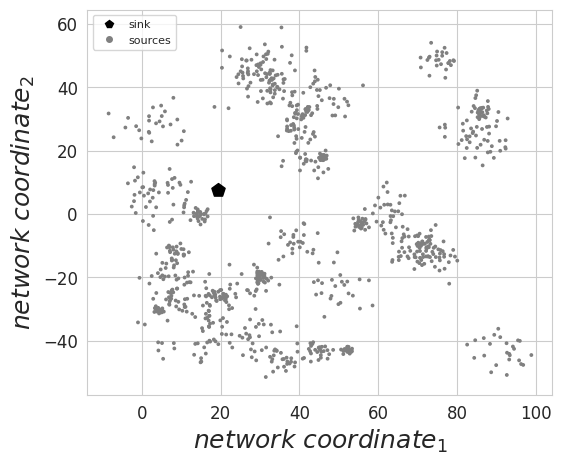

In [118]:
plt.rcParams.update({'font.size': 12})

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

tcolors = {"coordinator": "red", "worker": "grey"}
scat2 = prim_df.plot.scatter(ax=ax1, x="x", y="y", c=prim_df["type"].map(tcolors),
                             s=prim_df["capacity_" + str(100)] * 0.15)

ax1.set_xlabel('$network$ $coordinate_1$', fontsize=18)
ax1.set_ylabel('$network$ $coordinate_2$', fontsize=18)
ax1.scatter(coords[0, 0], coords[0, 1], color='grey')
plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs_plain.svg", bbox_inches="tight")

#plot coordinators
ax1.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')
ax1.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
#ax1.set_title('NES Topology in a Cost Space')
plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs.svg", bbox_inches="tight")
plt.show()

5
10
15
20
25
30
[0.4366208489016169, 0.4578903649217423, 0.49992119195341034, 0.5108058793595069, 0.5299915524594493, 0.5267786941386162, 0.5009227602975688, 0.4841569002362528, 0.5183732388175919, 0.5089759274551251, 0.5117896205451166, 0.5105253622412232, 0.5293334983994091, 0.5168366205208105, 0.5165437266976227, 0.5328298970637009, 0.5141888446038513, 0.5166973296098755, 0.508212798745317, 0.49082279488661057, 0.5001087379532659, 0.513173374582429, 0.492597708410025, 0.47799126712529283, 0.4678521377629234, 0.47591984822325606, 0.4667828622462073, 0.4670538328025685, 0.45841087810116826]
0.5328298970637009
Optimal k is  15


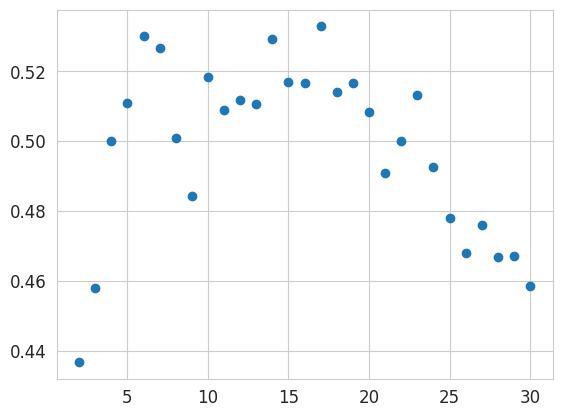

In [119]:
sil = []
kmin = 2  #max(2, centers - 5)
kmax = 30  #centers + 5
kseed = 20

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(kmin, kmax + 1):
    if k % 5 == 0:
        print(k)
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=kseed).fit(coords)
    labels = kmeans.labels_
    sil.append(silhouette_score(coords, labels, metric='euclidean'))

print(sil)

#opt_k = np.argmax(sil)
#opt_k = kmin + opt_k
opt_k = get_max_by_thresh(sil, 0.00)
print("Optimal k is ", opt_k)

cluster_alg = KMeans(n_clusters=opt_k, n_init='auto').fit(coords)
labels = cluster_alg.labels_
centroids = cluster_alg.cluster_centers_
plt.scatter(x=list(range(kmin, kmax + 1)), y=sil)

prim_df["cluster"] = labels
prim_df.loc[0, "cluster"] = -1

In [120]:
no_clusters = len(np.unique(labels))
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

color_list = sns.color_palette(n_colors=no_clusters)
colors = np.asarray(color_list.as_hex())
light_colors = [lighten_color(x) for x in colors]
color_list

Estimated no. of clusters: 15
Estimated no. of noise points: 0


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

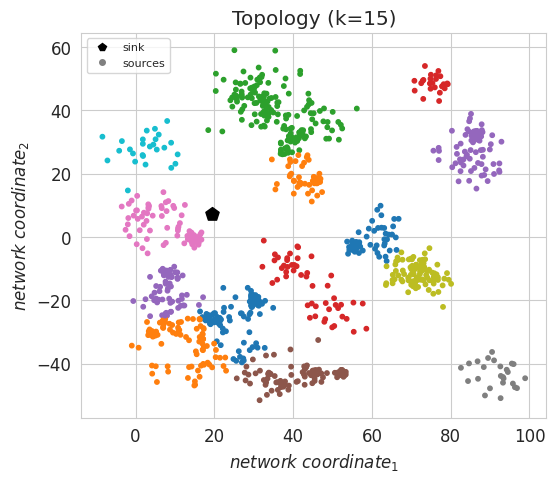

In [121]:
# add black color for outliers (if any)
super_figure = plt.figure(figsize=(6, 5))
super_plot = super_figure.add_subplot(111)
super_plot.scatter(coords[:, 0], coords[:, 1], s=10, color=colors[labels])
super_plot.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')

plt.savefig("plots/sim_1000/sim" + str(device_number - 1) + "_" + str(no_clusters) + ".svg", bbox_inches="tight")
plt.title('Topology (k=' + str(no_clusters) + ")")

plt.show()

### Experiment 2b: NEMO Aggregation with Density-based Grouping

In [137]:
# assign nodes to previous clustering alg
iterations = 10
max_levels = 50

slot_col = "capacity_100"
eval_name = "nemo"
weight_col = "weight"

eval_ig, df_dict_opt, opt_dict_opt = evaluate_nemo(prim_df, coords, centroids, [slot_col], iterations=iterations, max_levels=1,
                                  weight_col=weight_col, weighting="spring")
eval_matrix[eval_name], df_dict, opt_dict = evaluate_nemo(prim_df, coords, centroids, ["base", slot_col], iterations=iterations,
                                  weight_col=weight_col, weighting="spring", max_levels=50, show_eval=True)

Starting nemo for capacity_100 with spring and weight and level: 1
Evaluating for capacity_100
Starting nemo for base with spring and weight and level: 50
Evaluating for base
Starting nemo for capacity_100 with spring and weight and level: 50
Evaluating for capacity_100


In [124]:
df = df_dict[slot_col]
df

,oindex,x,y,type,cluster,total_weight,used_weight,total_capacity,free_capacity,level,parent
0,0,19.383905,7.406120,coordinator,-1,0,0,50,0,9,0
1,1,67.743232,-14.007158,worker,8,1,1,20,20,0,194
2,2,5.220579,-15.467092,worker,14,1,1,20,0,4,244
3,3,43.521014,41.129903,worker,2,5,5,20,20,0,806
4,4,14.195029,1.412734,worker,6,2,2,20,20,1,993
...,...,...,...,...,...,...,...,...,...,...,...
1233,998,40.609309,23.985392,worker,11,33,20,20,0,3,128
1234,998,40.609309,23.985392,worker,11,33,3,20,0,3,67
1235,999,31.878351,34.859971,worker,12,4,4,20,2,1,929
1236,1000,44.528343,34.090418,worker,2,18,2,20,20,0,124


In [125]:
df[df["parent"] == 0]

,oindex,x,y,type,cluster,total_weight,used_weight,total_capacity,free_capacity,level,parent
0,0,19.383905,7.406120,coordinator,-1,0,0,50,0,9,0
84,71,32.543847,-1.122257,worker,3,3,3,20,1,8,0
141,116,43.267057,31.777488,worker,2,2,2,20,0,8,0
167,136,42.330886,32.928113,worker,2,2,2,20,0,8,0
644,512,42.139053,33.779045,worker,2,40,40,20,0,8,0
918,731,42.540750,33.744616,worker,2,1,1,20,2,8,0
1088,873,16.042628,-1.744094,worker,6,1,1,20,0,8,0
1161,937,15.966873,-2.409084,worker,6,1,1,20,7,8,0


In [126]:
# check -> should be empty
df_overloaded = df.groupby(['parent'])['used_weight'].sum().copy().reset_index()
df_join = df[["oindex", "total_capacity", "free_capacity"]]
result = pd.merge(df_join, df_overloaded, left_on='oindex', right_on='parent', how='inner')
result["delta"] = result["total_capacity"] - result["used_weight"]
result[result["delta"] < 0]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [127]:
# check -> should be empty
result[result["delta"] != result["free_capacity"]]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [128]:
result

,oindex,total_capacity,free_capacity,parent,used_weight,delta
0,0,50,0,0,50,0
1,2,20,0,2,20,0
2,5,20,0,5,20,0
3,6,20,0,6,20,0
4,7,20,5,7,15,5
...,...,...,...,...,...,...
478,997,20,14,997,6,14
479,998,20,0,998,20,0
480,998,20,0,998,20,0
481,998,20,0,998,20,0


In [129]:
#create greedy aggregation tree
cluster_coords = centroids
cluster_coords_with_crd = np.column_stack((c_coords, cluster_coords.T)).T

mst = prim_mst(cluster_coords_with_crd)

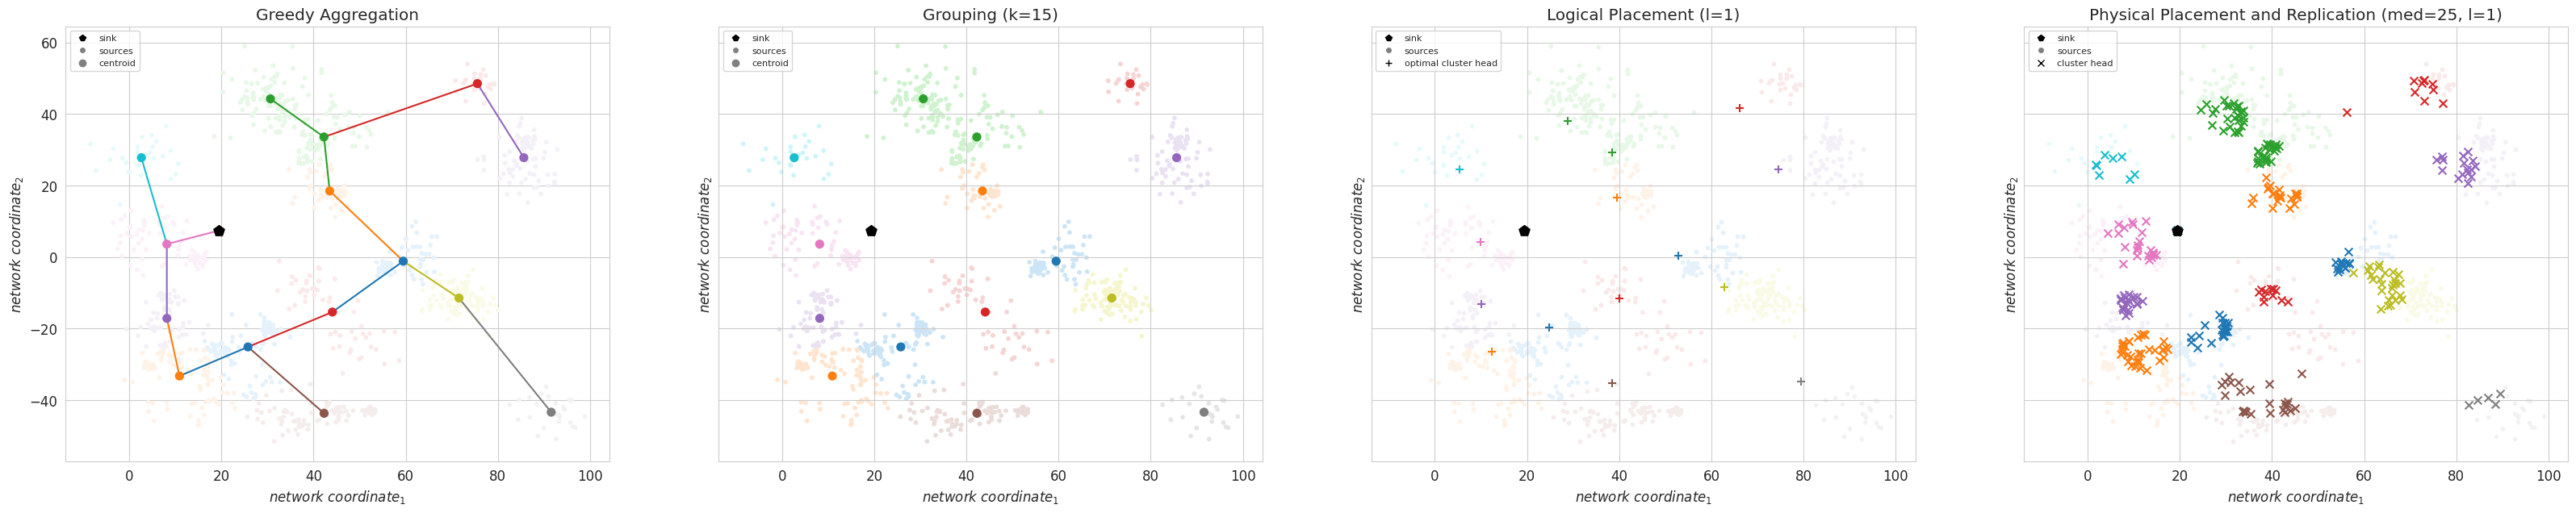

In [130]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.1

# plot greedy approach from MST
for i in range(1, len(mst)):
    point1 = cluster_coords_with_crd[i]
    point2 = cluster_coords_with_crd[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax1.plot(x_values, y_values, zorder=2, color=colors[i - 1])

ax1.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=10)
ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:len(cluster_coords)], zorder=3)
# in case all coords shall be plotted
ax1.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, lval) for x in colors[labels]])

lcentroid = Line2D([], [], color="blue", marker='o', linestyle='None', label='centroid')
ax1.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1),
           fontsize=8)

ax1.set_xlabel('$network$ $coordinate_1$')
ax1.set_ylabel('$network$ $coordinate_2$')
ax1.set_title('Greedy Aggregation')

#plot grouping
ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)

ax2.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1),
           fontsize=8)
ax2.set_title('Grouping (k=' + str(opt_k) + ")")
ax2.set_xlabel('$network$ $coordinate_1$')
ax2.set_ylabel('$network$ $coordinate_2$')

#plot our solutions
# util.plot2(ax3, prim_df, df_dict[slot_col], colors, lval=lval, show_centroids=True)
util.plot_optimum(ax3, prim_df, opt_dict[slot_col], colors, lval=lval, plot_centroid=False, plot_lines=False)
util.plot2(ax4, prim_df, df_dict_opt[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=False)

#plt.xlim(X_dim)
#plt.ylim(Y_dim)
ax3.set_title("Logical Placement (l=1)")
ax4.set_title("Physical Placement and Replication (med=" + str(25) + ", l=1)")

plt.savefig("plots/sim_1000/nemo_phases.svg", bbox_inches="tight")
plt.show()

Starting nemo for base with spring and weight and level: 1
Starting nemo for capacity_100 with spring and weight and level: 1
Starting nemo for base with spring and weight and level: 2
Starting nemo for capacity_100 with spring and weight and level: 2
Starting nemo for base with spring and weight and level: 5
Starting nemo for capacity_100 with spring and weight and level: 5
Starting nemo for base with spring and weight and level: 20
Starting nemo for capacity_100 with spring and weight and level: 20


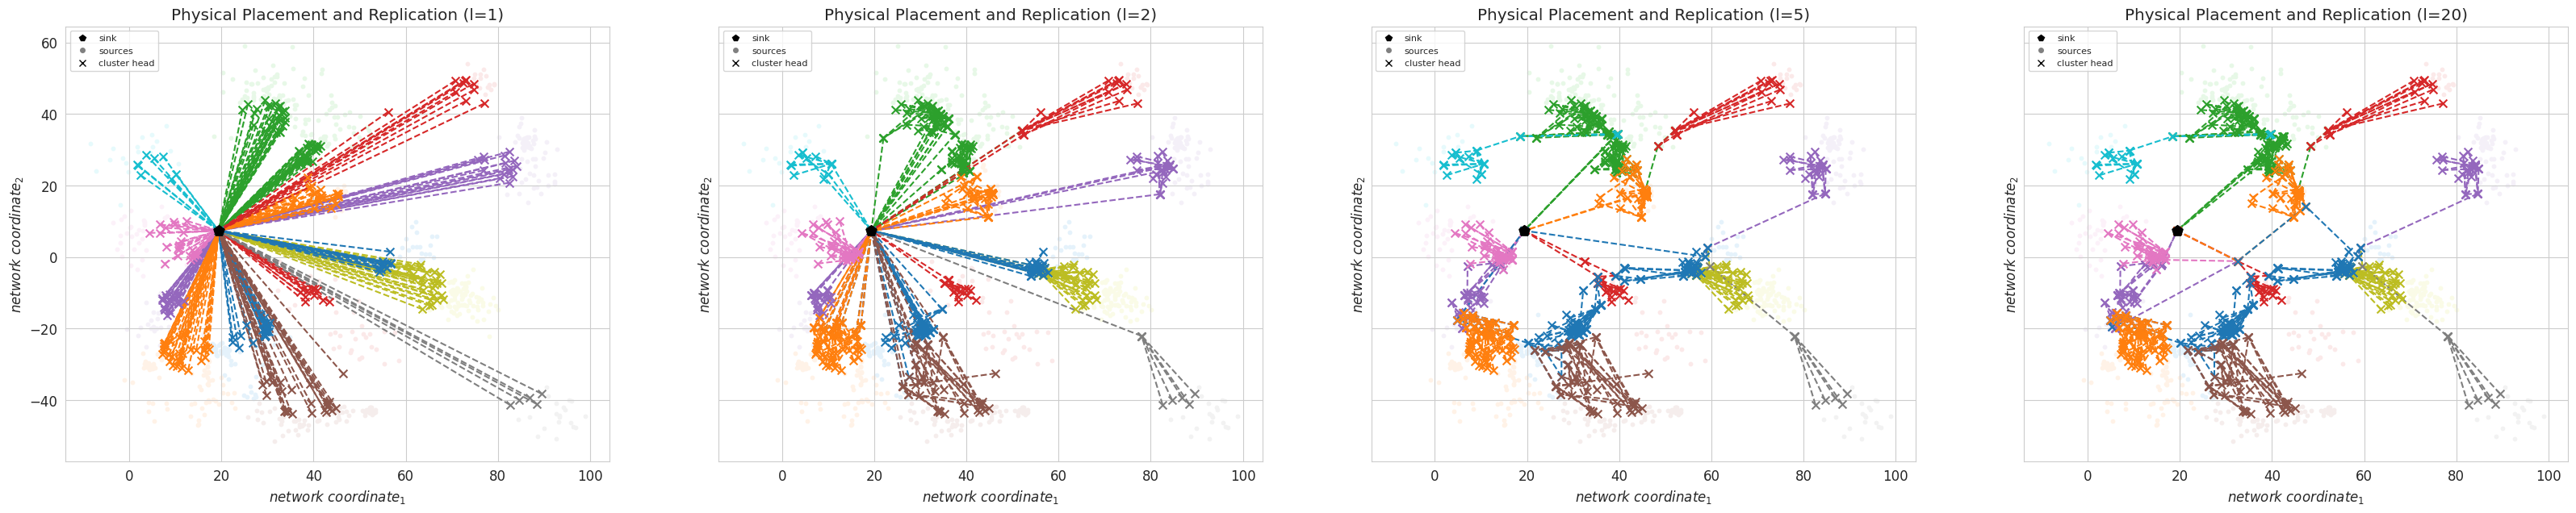

In [131]:
levels = [1, 2, 5, 20]
fig, axs = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.1

for i, level in enumerate(levels):
    eval_ig, df_dict_i, opt_dict_i = evaluate_nemo(prim_df, coords, centroids, ["base", slot_col], iterations=iterations,
                                          weight_col=weight_col, weighting="spring", max_levels=level, show_eval=False)
    util.plot2(axs[i], prim_df, df_dict_i[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=True)
    axs[i].set_title("Physical Placement and Replication (l=" + str(level) + ")")

plt.show()

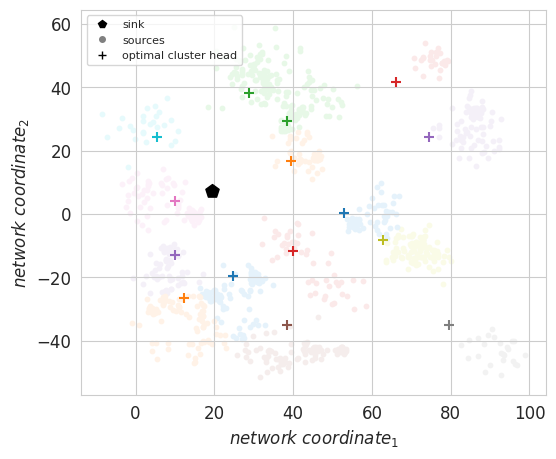

In [132]:
fig = plt.figure(figsize=(6, 5)).gca()

#uncomment this to plot nemo grouping
#ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
#ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
#ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)
#ax2.set_title('Grouping (k=' + str(opt_k) + ")")
#fig.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

#uncomment this for nemo placement
util.plot_optimum(fig, prim_df, opt_dict[slot_col], colors, lval=lval, plot_centroid=False, plot_lines=False)

#uncomment this for nemo redistribution
#util.plot(fig, new_paths_flat[slot_col], agg_dict_flat[slot_col], c_coords, cluster_coords, coords, colors, labels, changed_labels=reassigned_clussters, lval=lval)


fig.set_xlabel('$network$ $coordinate_1$')
fig.set_ylabel('$network$ $coordinate_2$')

#plt.savefig("plots/sim_1000/nemo_placement.svg", bbox_inches="tight")
plt.show()

## Evaluation

In [139]:
eval_matrix.keys()

dict_keys(['nemo'])

In [140]:
eval_matrix["nemo"].keys()

dict_keys(['base', 'capacity_100'])

In [147]:
eval_colors = {
    "nemo": colors[5],
    "nemo_base": "blue"
}

### Latency

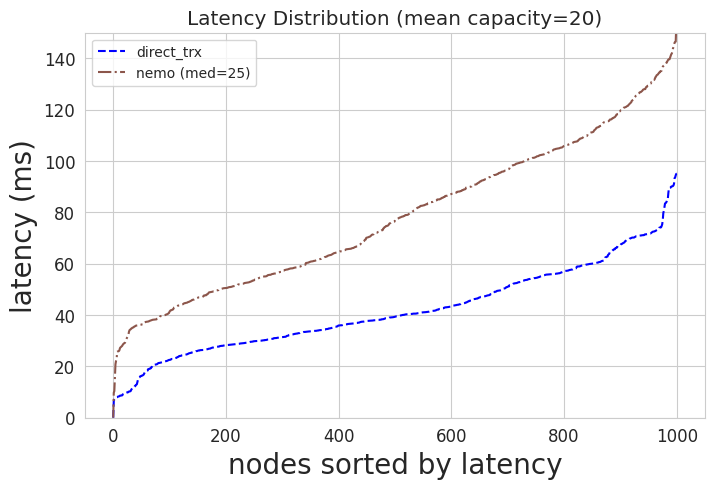

Means:  {'nemo (med=20)': 78.35}
Quantiles:  {'nemo (med=20)': 119.68}


In [148]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}
last_med_label = "25"

for l in eval_matrix.keys():
    emat = eval_matrix[l]

    i = 0
    for k, df in emat.items():
        #if i % 50 == 0:
        if l == "nemo" and k == "base":
            sv = df["latency_distribution"].sort_values()
            sv.plot(ax=ax1, use_index=False, label="direct_trx", color=eval_colors[l + "_base"], linestyle="--")
        elif k == "base":
            sv = df["latency_distribution"].sort_values()
            quant_dict[l] = round(sv.quantile(0.9), 2)
            mean_dict[l] = round(sv.mean(), 2)
            sv.plot(ax=ax1, use_index=False, label=l, color=eval_colors[l + "_base"], linestyle="--")
        elif k == "capacity_1":
            sv = df["latency_distribution"].sort_values()
            quant_dict[l + " (med=" + last_med_label + ")"] = round(sv.quantile(0.9), 2)
            mean_dict[l + " (med=" + last_med_label + ")"] = round(sv.mean(), 2)
            sv.plot(ax=ax1, use_index=False, label=l + " (med=" + last_med_label + ")", color=eval_colors[l],
                    linestyle="-.")
        elif k == "capacity_100":
            sv = df["latency_distribution"].sort_values()
            quant_dict[l + " (med=" + str(avg) + ")"] = round(sv.quantile(0.9), 2)
            mean_dict[l + " (med=" + str(avg) + ")"] = round(sv.mean(), 2)
            sv.plot(ax=ax1, use_index=False, label=l + " (med=" + last_med_label + ")", color=eval_colors[l],
                    linestyle="-.")
        i += 1

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
# Display a figure.
plt.ylim([0, 150])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

### Runtime

In [182]:
runtime_lognorm = []

# assign nodes to previous clustering alg
iterations = 10
rounds = 2

slot_col = "capacity_100"
eval_name = "nemo"
weight_col = "weight"
w1 = 1
w2 = 50

for r in range(rounds):
    print("Round", r)
    round_rt = []
    for i in range(w1, w2):
        if i % 10 == 0:
            print("Starting with weight [", w1, ",", i, "]")
        #prim_df[weight_col] = np.random.randint(1, 10, device_number)
        prim_df[weight_col] = get_lognorm_samples(w1, w2, device_number)
        start_time = timeit.default_timer()
        na, df_dict, opt_dict = evaluate_nemo(prim_df, coords, centroids, [slot_col], iterations=iterations,
                                          weight_col=weight_col, weighting="spring", show_eval=False)
        elapsed = timeit.default_timer() - start_time
        round_rt.append(elapsed)
        print("Elapsed:", elapsed)
    runtime_lognorm.append(round_rt)
runtime_lognorm = [sum(x) / len(runtime_lognorm) for x in zip(*runtime_lognorm)]

Round 0
Starting nemo for capacity_100 with spring and weight and level: 20
Elapsed: 0.7536053589974472
Starting nemo for capacity_100 with spring and weight and level: 20
Elapsed: 0.6527766869985498
Starting nemo for capacity_100 with spring and weight and level: 20
Elapsed: 0.6589480359980371
Starting nemo for capacity_100 with spring and weight and level: 20
Elapsed: 0.5519060709993937
Starting nemo for capacity_100 with spring and weight and level: 20
Elapsed: 0.5936376950012345
Starting nemo for capacity_100 with spring and weight and level: 20
Elapsed: 0.6092343350028386
Starting nemo for capacity_100 with spring and weight and level: 20
Elapsed: 0.6063815929992415
Starting nemo for capacity_100 with spring and weight and level: 20
Elapsed: 0.6280925370010664
Starting nemo for capacity_100 with spring and weight and level: 20
Elapsed: 0.6222220980016573
Starting with weight [ 1 , 10 ]
Starting nemo for capacity_100 with spring and weight and level: 20
Elapsed: 0.7125686010003847


In [183]:
runtime_lognorm

[0.6966197369984002,
 0.6504063789998327,
 0.6323311510004714,
 0.5791135454983305,
 0.5718996505001996,
 0.6202368710019073,
 0.629846842999541,
 0.663281207500404,
 0.709536043499611,
 0.6598416084998462,
 0.5929198780013394,
 0.6545432704988343,
 0.6762135355002101,
 0.6427915464992111,
 0.562334569000086,
 0.6298951629996736,
 0.6219357910013059,
 0.5735112444981496,
 0.6235948534995259,
 0.5646807315024489,
 0.616329100999792,
 0.5925629940011277,
 0.5617114334982034,
 0.5727058845004649,
 0.6478409129995271,
 0.5955165210016276,
 0.6242350884986081,
 0.6154464004994225,
 0.5790483034998033,
 0.5677786255000683,
 0.8244879425001272,
 0.5943115949994535,
 0.6069898570021905,
 0.6077763960001903,
 0.6335979895011405,
 0.5644679120014189,
 0.6437784604986518,
 0.5939189519995125,
 0.6341132109992031,
 0.5924303935007629,
 0.6208200464971014,
 0.8162229749996186,
 0.5849456839987397,
 0.6190596494998317,
 0.579977538998719,
 0.6338186145003419,
 0.5837202785005502,
 0.6243225485013681

In [185]:
runtime_uniform = []
w1 = 1
w2 = 18
rounds = 2

for r in range(rounds):
    round_rt = []
    for i in range(w1, w2):
        print("Starting with weight [", w1, ",", i, "]")
        prim_df[weight_col] = np.random.randint(1, i+1, device_number)
        #prim_df[weight_col] = get_lognorm_samples(w1, w2, device_number)
        start_time = timeit.default_timer()
        na, df_dict, opt_dict = evaluate_nemo(prim_df, coords, centroids, [slot_col], iterations=iterations,
                                          weight_col=weight_col, weighting="spring", show_eval=False)
        elapsed = timeit.default_timer() - start_time
        round_rt.append(elapsed)
        print("Elapsed:", elapsed)
    runtime_uniform.append(round_rt)
runtime_uniform = [sum(x) / len(runtime_uniform) for x in zip(*runtime_uniform)]

Starting with weight [ 1 , 1 ]
Starting nemo for capacity_100 with spring and weight and level: 20
Elapsed: 0.4526369949999207
Starting with weight [ 1 , 2 ]
Starting nemo for capacity_100 with spring and weight and level: 20
Elapsed: 0.42334528600258636
Starting with weight [ 1 , 3 ]
Starting nemo for capacity_100 with spring and weight and level: 20
Elapsed: 0.396594271001959
Starting with weight [ 1 , 4 ]
Starting nemo for capacity_100 with spring and weight and level: 20
Elapsed: 0.4161419219999516
Starting with weight [ 1 , 5 ]
Starting nemo for capacity_100 with spring and weight and level: 20
Elapsed: 0.4392705029968056
Starting with weight [ 1 , 6 ]
Starting nemo for capacity_100 with spring and weight and level: 20
Elapsed: 0.4426321899991308
Starting with weight [ 1 , 7 ]
Starting nemo for capacity_100 with spring and weight and level: 20
Elapsed: 0.5029269040023792
Starting with weight [ 1 , 8 ]
Starting nemo for capacity_100 with spring and weight and level: 20
Elapsed: 0.5

In [186]:
runtime_uniform

[0.3884296029991674,
 0.38384447600219573,
 0.36619724050069635,
 0.4047661335007433,
 0.4277491019984154,
 0.4359326214998873,
 0.492045072502151,
 0.5273279850007384,
 0.5460965050024242,
 0.6076491295007145,
 0.8262850165010605,
 0.7043943575008598,
 0.7664540784990095,
 0.8749510200013901,
 0.8655286760003946,
 0.9087882184994669,
 0.9892109749998781]

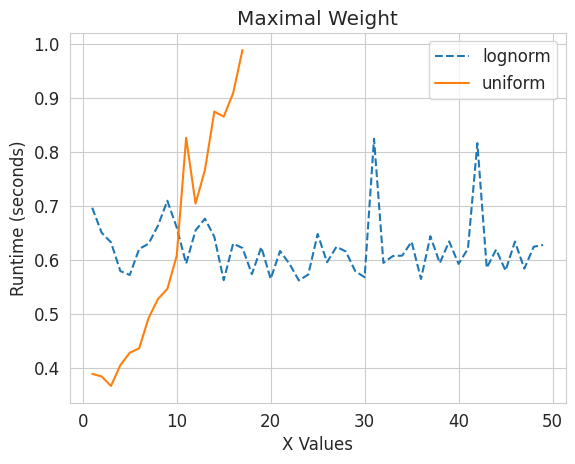

In [187]:
# Your lists of x and y values (runtime)
x_values = [1, 2, 3, 4, 5]  # Replace with your actual x values
y_values = [10.2, 15.1, 18.5, 22.7, 30.2]  # Replace with your actual y (runtime) values

# Create a line plot
plt.plot(range(1, len(runtime_lognorm) + 1), runtime_lognorm, linestyle = "--", label="lognorm")
plt.plot(range(1, len(runtime_uniform) + 1), runtime_uniform, linestyle = "-", label="uniform")


# Add labels and a title
plt.xlabel("X Values")
plt.ylabel("Runtime (seconds)")
plt.title("Maximal Weight")

plt.legend()

# Show the plot
plt.show()